# Проект - Подсчет количества людей в магазине

Дисциплина "Проектиорвание нейроных сетей для задач анализа изображений", ИТМО 2025

Выполнили: 
студенты 1 курса магистратуры направления МиКМ 25
- Трефилов Яков 
- Диль Диана 
- Киселева Анастасия
- Ракич Тина
- Давыдова Ульяна
- Душкина Надежда


(from README.md)
### Overview

**Consumers** includes images of retail consumers captured from RGB cameras and their ground truth bounding-box locations.

**BID** comprises cropped full-body images of annotated consumers with their ground truth age-range and gender information.

Both datasets are anonymized following the *privacy-by-design* principle, and their use is intended for various computer vision tasks. However, it is not limited to these tasks. Please refer to the sections below for important information regarding the use of this dataset.

This version  only includes the **evaluation** (test) set partitions. We will soon upload the training partitions as well.

### Structure

- **Consumers** includes 145 video sequences split into 120 training and 25 testing partitions featuring 8700 images/frames in total. The structure of the dataset is as follows:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F17922636%2F064ee2e51239f2c5b0a5e38685689be4%2FConsumersSmall.png?generation=1701373217319160&alt=media)

where *gt.txt* includes the holistic annotation information [frame_id, consumer_id, bounding-box] for the entire sequence, readily available for evaluating the tracking algorithm (i.e., compatible with MOT challenge format). Each frameID.txt contains annotation information [consumer_ID bounding_box_coords(center point, box width, and height) age_group gender] per annotated instance in the frame.

- **BID** (body image dataset) comrpises 6641 cropped images from each *Consumers* sequence, split into 5507 training images and 1134 images for testing. The structure of the dataset is as follows:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F17922636%2Fadb4074045b5abc61903eacb8ecbbe1f%2FBIDStructureSmall.png?generation=1701373230351014&alt=media)
  
- We consider four age groups: (1) below 12–20 years, (2) 21–36, (3) 37–60, and (4) over 61,
and each cropped body image corresponds to a single instance of a target consumer, which is also reflected by the image name (frameID_consumerID)
- Annotations are provided within *index.txt* in the format: [GENDER AGE_GROUP_1 AGE_GROUP_2 AGE_GROUP_3 AGE_GROUP_4]. For example, the 1 hot representation [1 0 1 0 0] denotes a consumer instance of a female in the 21 to 36 age group.

## Code

In [1]:
!pip install kagglehub

In [2]:
# !pip install matplotlib

In [3]:
!pip install torch torchvision albumentations

In [4]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import csv

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset
import random

import kagglehub

In [5]:
# Download latest version
path = kagglehub.dataset_download("angelosgiotis/consumers-bid")

print("Path to dataset files:", path)

100%|██████████| 850M/850M [00:08<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/angelosgiotis/consumers-bid/versions/6


In [6]:
class ConsumersGTDataset(Dataset):
    """
    Dataset for Consumers sequences where each sequence folder contains images and a `gt/gt.txt`.
    Root structure:
      root/
        Sequence_ID000/
          img_00001.jpg
          img_00002.jpg
          gt/
            gt.txt
        Sequence_ID001/
          ...
        gt.txt format (no header), each line:
            photo_id, consumer_id, x_top_left, y_top_left, width, height
        Coordinates are assumed to be top-left corner (x, y, width, height).
        photo_id may include extension or be just frame id.
    """

    def __init__(self, root, sequences=None, transform=None,
                 img_extensions=('.jpg', '.jpeg', '.png'), try_find=True):
        self.root = Path(root)
        if not self.root.exists():
            raise FileNotFoundError(f"Root path does not exist: {self.root}")
        self.transform = transform
        self.img_extensions = tuple(e.lower() for e in img_extensions)
        self.try_find = try_find

        # list sequences (directories) to scan
        if sequences is None:
            sequences = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        self.sequences = sequences

        # mapping image_path -> list of anns
        self._anns = {}  # Path -> list of (consumer_id, cx, cy, w, h, normalized_flag_guess)
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            gt_path = seq_dir / 'gt' / 'gt.txt'
            if not gt_path.exists():
                # skip sequences without gt
                continue
            # parse gt file
            with open(gt_path, 'r', encoding='utf-8') as f:
                first = f.readline()
                # decide delimiter
                if ',' in first:
                    delimiter = ','
                else:
                    delimiter = None
                # re-open to iterate from start
            with open(gt_path, 'r', encoding='utf-8') as f:
                if delimiter:
                    reader = csv.reader(f, delimiter=delimiter)
                else:
                    reader = csv.reader(f, delimiter=None, skipinitialspace=True)
                for row in reader:
                    if not row:
                        continue
                    # normalize and filter blank parts
                    row = [r.strip() for r in row if r is not None and str(r).strip() != '']
                    if len(row) < 6:
                        continue
                    photo_id_raw = row[0]
                    try:
                        consumer_id = int(row[1])
                        x_tl = float(row[2])
                        y_tl = float(row[3])
                        w_box = float(row[4])
                        h_box = float(row[5])
                    except Exception:
                        continue

                    # resolve image path inside this sequence
                    img_path = self._resolve_image_path(seq_dir, photo_id_raw)
                    if img_path is None:
                        # not found; optionally try slower search inside seq_dir
                        if self.try_find:
                            img_path = self._fuzzy_find(seq_dir, photo_id_raw)
                    if img_path is None:
                        # skip annotations without image match
                        continue

                    # guess whether coordinates are normalized (0..1)
                    normalized_guess = (0.0 <= x_tl <= 1.0 and 0.0 <= y_tl <= 1.0 and 0.0 <= w_box <= 1.0 and 0.0 <= h_box <= 1.0)

                    key = str(img_path.resolve())
                    self._anns.setdefault(key, []).append((consumer_id, x_tl, y_tl, w_box, h_box, normalized_guess))

        # Build items: include all image files in the scanned sequences
        # even if they have no annotations (we'll return empty targets for those)
        items = []
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            for p in sorted(seq_dir.iterdir()):
                if p.is_file() and p.suffix.lower() in self.img_extensions:
                    items.append(p)
        # keep only those images that are within the sequences we scanned
        # final items stored as resolved Paths
        self.items = [p.resolve() if isinstance(p, Path) else Path(p).resolve() for p in items]

    def _resolve_image_path(self, seq_dir: Path, photo_id_raw: str):
        """
        Try direct resolution: seq_dir / photo_id_raw, or append extensions if missing.
        Returns Path or None.
        """
        pid = photo_id_raw
        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p
        # if pid contains subdirs, try relative path
        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p
        # try with extensions
        if not Path(pid).suffix:
            for ext in self.img_extensions:
                candidate = seq_dir / (pid + ext)
                if candidate.exists():
                    return candidate
        # sometimes photo_id includes a sequence prefix; try only filename
        name = Path(pid).name
        p = seq_dir / name
        if p.exists():
            return p
        return None

    def _fuzzy_find(self, seq_dir: Path, photo_id_raw: str):
        """
        Slower fallback: search files in seq_dir for filename containing photo_id_raw.
        """
        pid = photo_id_raw.lower()
        for p in seq_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in self.img_extensions:
                if pid in p.name.lower():
                    return p
        return None

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path = self.items[idx]
        ann_list = self._anns.get(str(img_path.resolve()), [])
        img = Image.open(img_path).convert('RGB')
        w_img, h_img = img.size

        boxes = []
        ids = []
        for (cid, x_tl, y_tl, w_box, h_box, normalized_guess) in ann_list:
            if normalized_guess:
                # normalized top-left coordinates -> convert to pixels
                x_px = x_tl * w_img
                y_px = y_tl * h_img
                w_px = w_box * w_img
                h_px = h_box * h_img
            else:
                x_px, y_px, w_px, h_px = x_tl, y_tl, w_box, h_box

            # top-left (x_px,y_px,w_px,h_px) -> x1,y1,x2,y2
            x1 = x_px
            y1 = y_px
            x2 = x_px + w_px
            y2 = y_px + h_px

            # clip
            x1 = max(0.0, x1)
            y1 = max(0.0, y1)
            x2 = min(float(w_img), x2)
            y2 = min(float(h_img), y2)

            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])
            ids.append(int(cid))

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            ids = torch.tensor(ids, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            ids = torch.tensor([], dtype=torch.long)

        target = {
            'boxes': boxes,
            'ids': ids,
            'image_id': torch.tensor([idx]),
            'file_path': str(img_path)
        }

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        return img, target


def collate_detection(batch):
    """
    Collate that returns images (stacked if same shape) and list of target dicts.
    """
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    # Try stacking — will raise if shapes differ
    try:
        images = torch.stack(images, dim=0)
    except Exception:
        # keep list of tensors
        pass
    return images, targets

Shown image 0 with 1 boxes


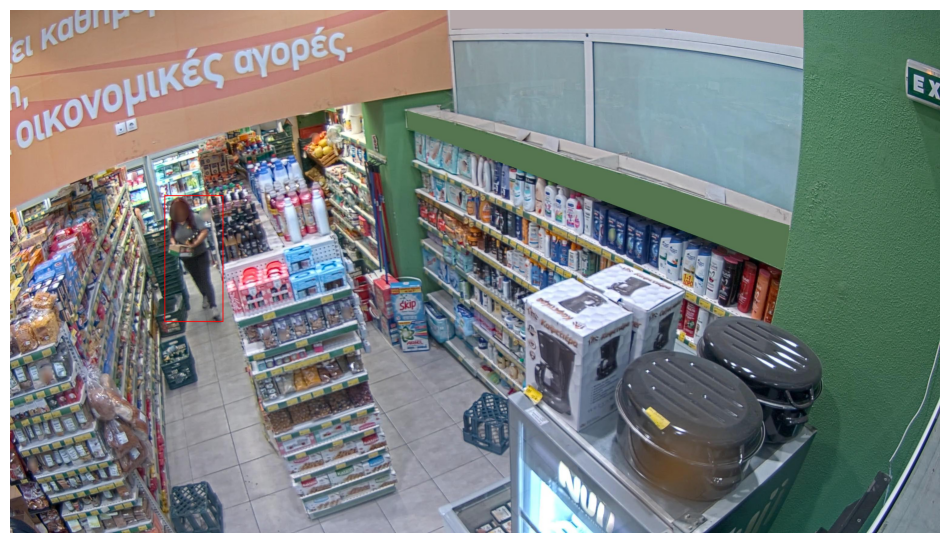

In [7]:
# Пример: создать датасет и визуализировать боксы для произвольного индекса

# Трансформы — по желанию (визуализация использует исходный файл для точных координат)
#val_transform = transforms.Compose([
    #transforms.Resize((480, 854)),   # опционально
#    transforms.ToTensor()
#])

# Если вы использовали kagglehub выше, переменная `path` указывает на распакованный датасет.
# Настройте root на реальную папку с Sequence_* каталогами. Например: Path(path)/'Consumers'
from pathlib import Path
dataset_root = Path(path) / 'Consumers' if 'path' in globals() else Path('path/to/dataset_root')
#dataset = ConsumersGTDataset(root=dataset_root, transform=val_transform)
dataset = ConsumersGTDataset(root=dataset_root, transform=None)

def visualize_idx(dataset, idx, figsize=(12,8), show=True):
    img_tensor, target = dataset[idx]
    fp = target.get('file_path', None)
    # Open original image when available to draw in pixel coords
    if fp is not None and Path(fp).exists():
        pil_img = Image.open(fp).convert('RGB')
    else:
        pil_img = ToPILImage()(img_tensor)

    draw = ImageDraw.Draw(pil_img)
    boxes = target.get('boxes')
    ids = target.get('ids')
    if boxes is not None and boxes.numel() > 0:
        boxes_np = boxes.detach().cpu().numpy()
        ids_np = ids.detach().cpu().numpy() if ids is not None and ids.numel() > 0 else [None]*len(boxes_np)
        for b, cid in zip(boxes_np, ids_np):
            x1,y1,x2,y2 = b
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
            label = str(int(cid)) if cid is not None else ''
            # label background
            text_pos = (max(0, x1), max(0, y1-12))
            draw.text(text_pos, label, fill='yellow')
    if show:
        plt.figure(figsize=figsize)
        plt.imshow(pil_img)
        plt.axis('off')
    return pil_img, target

# Визуализируем первый элемент (или укажите другой индекс)
if len(dataset) == 0:
    print('Dataset is empty — проверьте путь `dataset_root` и наличие gt/gt.txt в sequence папках')
else:
    pil_img, target = visualize_idx(dataset, 350)
    print('Shown image 0 with', target.get('boxes').shape[0], 'boxes')

In [8]:
# Augmentation + train/val split using existing ConsumersGTDataset (no new Dataset class)

# Define bbox-aware albumentations transforms (expects bboxes in pascal_voc: [x1,y1,x2,y2])
train_alb = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.Resize(480, 854)
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.0))

val_alb = A.Compose([
    #A.Resize(480, 854)
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.0))

# collate factory that applies albumentations per-sample using original file_path from target
def make_collate(alb_transform):
    to_tensor = ToTensor()
    def collate_fn(batch):
        images_out = []
        targets_out = []
        for img_tensor, target in batch:
            fp = target.get('file_path', None)
            boxes = target.get('boxes')
            ids = target.get('ids')
            if boxes is None or boxes.numel() == 0:
                bboxes = []
                labels = []
            else:
                bboxes = boxes.detach().cpu().numpy().tolist()
                labels = ids.detach().cpu().numpy().tolist()

            if fp is not None and Path(fp).exists():
                # open original image (PIL) to apply albumentations in pixel coords
                pil = Image.open(fp).convert('RGB')
                img_np = np.array(pil)
                try:
                    aug = alb_transform(image=img_np, bboxes=bboxes, labels=labels)
                    img_np = aug['image']
                    bboxes = aug.get('bboxes', [])
                    labels = aug.get('labels', [])
                except Exception:
                    # if augmentation fails (e.g., wrong bbox format), fallback to original
                    img_np = np.array(pil)
            else:
                # No file path: try to use provided tensor (already transformed) — convert to PIL then to numpy
                try:
                    pil = ToPILImage()(img_tensor)
                    img_np = np.array(pil)
                    aug = alb_transform(image=img_np, bboxes=bboxes, labels=labels) if alb_transform is not None else {'image':img_np,'bboxes':bboxes,'labels':labels}
                    img_np = aug['image']
                    bboxes = aug.get('bboxes', [])
                    labels = aug.get('labels', [])
                except Exception:
                    # fallback: convert tensor directly
                    img_np = img_tensor.detach().cpu().numpy().transpose(1,2,0)

            # convert to tensor
            img_t = to_tensor(img_np)
            images_out.append(img_t)

            if bboxes:
                boxes_t = torch.tensor(bboxes, dtype=torch.float32)
                ids_t = torch.tensor(labels, dtype=torch.long)
            else:
                boxes_t = torch.zeros((0,4), dtype=torch.float32)
                ids_t = torch.tensor([], dtype=torch.long)

            new_target = {'boxes': boxes_t, 'ids': ids_t, 'image_id': target.get('image_id', torch.tensor([-1])), 'file_path': target.get('file_path')}
            targets_out.append(new_target)

        # try stacking images (may fail if shapes differ)
        try:
            images_out = torch.stack(images_out, dim=0)
        except Exception:
            pass
        return images_out, targets_out
    return collate_fn

# Split indices helper
def split_indices(dataset, val_ratio=0.2, seed=42):
    n = len(dataset)
    idx = list(range(n))
    rnd = random.Random(seed)
    rnd.shuffle(idx)
    split = int(n*(1-val_ratio))
    return idx[:split], idx[split:]

# Build base dataset (no transform here; collate will handle resizing/augmentation)
base_ds = ConsumersGTDataset(root=dataset_root, transform=None)
train_idx, val_idx = split_indices(base_ds, val_ratio=0.2, seed=42)
train_base = Subset(base_ds, train_idx)
val_base = Subset(base_ds, val_idx)

#train_loader = DataLoader(train_base, batch_size=16, shuffle=True, num_workers=4, collate_fn=make_collate(train_alb), pin_memory=True)
#val_loader = DataLoader(val_base, batch_size=8, shuffle=False, num_workers=4, collate_fn=make_collate(val_alb), pin_memory=True)
#train_loader = DataLoader(train_base, batch_size=16, shuffle=True, num_workers=4, collate_fn=make_collate(train_alb), pin_memory=True)
#val_loader = DataLoader(val_base, batch_size=8, shuffle=False, num_workers=4, collate_fn=make_collate(val_alb), pin_memory=True)

print('Sizes — all:', len(base_ds), 'train:', len(train_base), 'val:', len(val_base))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Sizes — all: 1466 train: 1172 val: 294


Кратко и просто:

- Есть `train_loader` и `val_loader` для обучения и валидации.
- Используется `ConsumersGTDataset` для загрузки изображений и bbox.
- Для аугментаций есть трансформации и collate-функция (`make_collate`).
- Функция `visualize_idx(dataset, idx)` показывает изображение с нарисованными bounding-box и id.


Готово — можно запускать обучение или посмотреть примеры батча/визуализации.


# Подготовка данных для Faster R-CNN

В дальнейшей части проекта мы планируем использовать детектор
объектов Faster R-CNN (fasterrcnn_resnet50_fpn из torchvision)
для задачи подсчёта людей в магазине.

 Эта модель ожидает, что датасет для каждого изображения будет
возвращать:

```
   img: Tensor[C, H, W]
   target: словарь с ключами
       "boxes"  -> Tensor[N, 4]  (x1, y1, x2, y2)
       "labels" -> Tensor[N]     (int64, класс каждого бокса)
       (опционально: "image_id", "area", "iscrowd", ...)

```

Наш ConsumersGTDataset уже умеет читать изображения и боксы людей,
но сейчас он возвращает словарь вида:
```
{
       "boxes": Tensor[N, 4],
       "ids":   Tensor[N],      # идентификатор consumer_id, а не класс
       "image_id": ...,
       "file_path": ...
}
```



Для обучения Faster R-CNN нам нужно привести таргеты к формату
 {"boxes", "labels"} и ввести разметку классов. В текущей задаче
 у нас один тип объекта — "person", поэтому всем боксам
 ставим один и тот же класс: label = 1.

 Ниже определяем обёртку DetectionConsumersDataset, которая
 адаптирует ConsumersGTDataset к формату, ожидаемому Faster R-CNN,
 и собираем новые DataLoader'ы для обучения детектора.


In [9]:
#import torch
#from torch.utils.data import Dataset

class DetectionConsumersDataset(Dataset):

    def __init__(self, base_ds):
        self.base_ds = base_ds

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        img, target = self.base_ds[idx]

        boxes = target["boxes"]

        # Один класс person метка 1 для каждого бокса
        if boxes.shape[0] > 0:
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            labels = torch.zeros((0,), dtype=torch.int64)

        image_id = target.get("image_id", torch.tensor([idx]))

        target_out = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id
        }

        return img, target_out


In [10]:
class DetectionConsumersDataset(Dataset):
    def __init__(self, base_ds, transforms=None):
        """
        base_ds must return:
            img: PIL image or numpy array (H, W, C)
            target: dict with key 'boxes' in pascal_voc format
        """
        self.base_ds = base_ds
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = self.base_ds[idx]

        # Boxes must be (N, 4) in pascal_voc
        boxes = target["boxes"]

        # Single class: person -> label = 1
        if boxes.shape[0] > 0:
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            labels = torch.zeros((0,), dtype=torch.int64)

        # Albumentations expects numpy
        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).cpu().numpy()

        boxes_np = boxes.cpu().numpy()
        labels_np = labels.cpu().numpy()

        if self.transforms is not None:
            augmented = self.transforms(
                image=img,
                bboxes=boxes_np,
                labels=labels_np
            )

            img = augmented["image"]           # Tensor [C,H,W] (ToTensorV2)
            boxes = torch.as_tensor(
                augmented["bboxes"], dtype=torch.float32
            )
            labels = torch.as_tensor(
                augmented["labels"], dtype=torch.int64
            )
        else:
            # If no Albumentations, ensure tensor format
            img = torch.as_tensor(img).permute(2, 0, 1)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        return img, target

    def __len__(self):
        return len(self.base_ds)

In [11]:
def detection_collate_fn(batch):
    """
    batch: список [(img, target), (img, target), ...]
    Возвращает:
        images:  список тензоров
        targets: список словарей
    """
    return tuple(zip(*batch))


In [12]:
# обертки поверх train_base и val_base
train_det_ds = DetectionConsumersDataset(train_base, transforms = train_alb)
val_det_ds   = DetectionConsumersDataset(val_base, transforms = val_alb)

# DataLoader'ы для обучения Faster R-CNN
from torch.utils.data import DataLoader

train_det_loader = DataLoader(
    train_det_ds,
    batch_size=8,
    shuffle=True,
    collate_fn=detection_collate_fn
)

val_det_loader = DataLoader(
    val_det_ds,
    batch_size=8,
    shuffle=False,
    collate_fn=detection_collate_fn
)

print("Detection train size:", len(train_det_ds))
print("Detection val size:  ", len(val_det_ds))


Detection train size: 1172
Detection val size:   294


In [13]:
images_batch, targets_batch = next(iter(train_det_loader))

print("Batch size:", len(images_batch))
print("Image shape:", images_batch[0].shape)
print("Keys in target:", targets_batch[0].keys())
print("Boxes shape:", targets_batch[0]["boxes"].shape)
print("Labels:", targets_batch[0]["labels"])


Batch size: 8
Image shape: torch.Size([3, 1728, 3072])
Keys in target: dict_keys(['boxes', 'labels', 'image_id'])
Boxes shape: torch.Size([1, 4])
Labels: tensor([1])


# Импорт модели и создание Faster R-CNN

In [14]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

#num_classes = 2

#in_features = model.roi_heads.box_predictor.cls_score.in_features

#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#model = model.to(device)

#print(model)


Device: cuda


In [15]:
# более легкая модель
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Small backbone
backbone = torchvision.models.resnet18(weights="DEFAULT")
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 512

# Anchor generator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

num_classes = 2
# Faster R-CNN model
model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [16]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
       

In [17]:
# проверка на 1 батче

images_batch, targets_batch = next(iter(train_det_loader))

images_batch = [img.to(device) for img in images_batch]
targets_batch = [{k: v.to(device) for k, v in t.items()} for t in targets_batch]

model.train()
loss_dict = model(images_batch, targets_batch)
losses = sum(loss for loss in loss_dict.values())

print("Loss dict:", {k: float(v) for k, v in loss_dict.items()})
print("Total loss:", float(losses))


Loss dict: {'loss_classifier': 0.6990505456924438, 'loss_box_reg': 0.006785315461456776, 'loss_objectness': 0.6730675101280212, 'loss_rpn_box_reg': 0.005836824886500835}
Total loss: 1.3847402334213257


/tmp/ipython-input-3467361477.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("Loss dict:", {k: float(v) for k, v in loss_dict.items()})


### Обучение модели

In [18]:
from tqdm import tqdm
import copy

In [19]:
# COCO evaluator
from torchvision.datasets import CocoDetection
from torchvision.models.detection import MaskRCNN

In [20]:
from torchvision.ops import box_iou

def compute_iou(outputs, targets):
    """
    Computes mean IoU between predicted boxes and ground truth boxes.
    outputs: list of dicts with 'boxes'
    targets: list of dicts with 'boxes'
    """
    ious = []
    for out, tgt in zip(outputs, targets):
        if len(out['boxes']) == 0 or len(tgt['boxes']) == 0:
            continue
        iou = box_iou(out['boxes'], tgt['boxes'])
        ious.append(iou.max().item())  # max IoU per predicted box
    return sum(ious) / len(ious) if len(ious) > 0 else 0.0


In [21]:
def train_detection_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    lr_scheduler,
    device,
    num_epochs=20,
    save_path="best_model.pth"
):
    """
    Train an object detection model tracking:
      - Train loss
      - Train mean IoU
      - Validation mean IoU
    Saves the best model based on validation IoU.
    """
    history = {"train_loss": [], "train_mIoU": [], "val_mIoU": []}
    best_mIoU = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    model.to(device)

    for epoch in range(num_epochs):
        # -----------------------------
        # Training
        # -----------------------------
        model.train()
        running_loss = 0.0
        train_ious = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", unit="batch")
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

            # Compute train IoU
            model.eval()
            with torch.no_grad():
                outputs = model(images)
                train_ious.append(compute_iou(outputs, targets))
            model.train()

            pbar.set_postfix({"loss": losses.item()})

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_iou = sum(train_ious) / len(train_ious) if len(train_ious) > 0 else 0.0

        history["train_loss"].append(epoch_train_loss)
        history["train_mIoU"].append(epoch_train_iou)

        # -----------------------------
        # Validation
        # -----------------------------
        model.eval()
        val_ious = []

        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", unit="batch")
            for images, targets in pbar_val:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


                # Compute validation IoU
                outputs = model(images)
                val_ious.append(compute_iou(outputs, targets))

        epoch_val_iou = sum(val_ious) / len(val_ious) if len(val_ious) > 0 else 0.0

        history["val_mIoU"].append(epoch_val_iou)

        print(
            f"\nEpoch {epoch+1}/{num_epochs} — "
            f"Train Loss: {epoch_train_loss:.4f}, Train mIoU: {epoch_train_iou:.4f}, "
            f"Val mIoU: {epoch_val_iou:.4f}"
        )

        # Step LR scheduler
        lr_scheduler.step()

        # Save best model based on validation IoU
        if epoch_val_iou > best_mIoU:
            best_mIoU = epoch_val_iou
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Saved new best model (Val mIoU improved to {epoch_val_iou:.4f})")

    print("Training complete!")
    return history, best_model_wts


In [22]:
# 2 batch

class TwoBatchDataset(torch.utils.data.Dataset):
    def __init__(self, batches):
        self.batches = batches

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        return self.batches[idx]   # return (images, targets) directly

def identity_collate(batch):
    return batch[0]   # simply return (images, targets)


it = iter(train_det_loader)
batch1 = next(it)
batch2 = next(it)
batch3 = next(it)
batch4 = next(it)
batch5 = next(it)

two_batch_loader = torch.utils.data.DataLoader(
    TwoBatchDataset([batch1, batch2, batch3, batch4, batch5]),
    batch_size=1,   # because each item in the dataset is already one batch
    shuffle=False,
    collate_fn=identity_collate
)

it = iter(val_det_loader)
batch1 = next(it)
batch2 = next(it)
batch3 = next(it)
batch4 = next(it)
batch5 = next(it)

val_two_batch_loader = torch.utils.data.DataLoader(
    TwoBatchDataset([batch1, batch2, batch3, batch4, batch5]),
    batch_size=1,   # because each item in the dataset is already one batch
    shuffle=False,
    collate_fn=identity_collate
)



In [23]:
# Обучение модели
# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr = 0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train
history, best_weights = train_detection_model(
    model=model,
    train_loader=train_det_loader,
    val_loader=val_det_loader,
    #train_loader = two_batch_loader,
    #val_loader = val_two_batch_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
    num_epochs = 15,
    save_path="SGD_15epochs_lr0.005_with_augmentations.pth"
)

# Load best model
model.load_state_dict(best_weights)


Epoch 1/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.68s/batch]



Epoch 1/15 — Train Loss: 0.1656, Train mIoU: 0.4922, Val mIoU: 0.7103
Saved new best model (Val mIoU improved to 0.7103)


Epoch 2/15 [Validation]: 100%|██████████| 37/37 [01:00<00:00,  1.62s/batch]



Epoch 2/15 — Train Loss: 0.0811, Train mIoU: 0.7263, Val mIoU: 0.7469
Saved new best model (Val mIoU improved to 0.7469)


Epoch 3/15 [Validation]: 100%|██████████| 37/37 [01:00<00:00,  1.64s/batch]



Epoch 3/15 — Train Loss: 0.0647, Train mIoU: 0.7697, Val mIoU: 0.7872
Saved new best model (Val mIoU improved to 0.7872)


Epoch 4/15 [Validation]: 100%|██████████| 37/37 [01:01<00:00,  1.66s/batch]



Epoch 4/15 — Train Loss: 0.0594, Train mIoU: 0.7780, Val mIoU: 0.7930
Saved new best model (Val mIoU improved to 0.7930)


Epoch 5/15 [Validation]: 100%|██████████| 37/37 [01:00<00:00,  1.64s/batch]



Epoch 5/15 — Train Loss: 0.0593, Train mIoU: 0.7835, Val mIoU: 0.7999
Saved new best model (Val mIoU improved to 0.7999)


Epoch 6/15 [Validation]: 100%|██████████| 37/37 [01:01<00:00,  1.66s/batch]



Epoch 6/15 — Train Loss: 0.0586, Train mIoU: 0.7913, Val mIoU: 0.8031
Saved new best model (Val mIoU improved to 0.8031)


Epoch 7/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.68s/batch]



Epoch 7/15 — Train Loss: 0.0566, Train mIoU: 0.7970, Val mIoU: 0.7974


Epoch 8/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.69s/batch]



Epoch 8/15 — Train Loss: 0.0574, Train mIoU: 0.7970, Val mIoU: 0.8073
Saved new best model (Val mIoU improved to 0.8073)


Epoch 9/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.69s/batch]



Epoch 9/15 — Train Loss: 0.0577, Train mIoU: 0.7875, Val mIoU: 0.8108
Saved new best model (Val mIoU improved to 0.8108)


Epoch 10/15 [Validation]: 100%|██████████| 37/37 [01:00<00:00,  1.64s/batch]



Epoch 10/15 — Train Loss: 0.0571, Train mIoU: 0.7946, Val mIoU: 0.7998


Epoch 11/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.70s/batch]



Epoch 11/15 — Train Loss: 0.0560, Train mIoU: 0.7981, Val mIoU: 0.8052


Epoch 12/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.69s/batch]



Epoch 12/15 — Train Loss: 0.0565, Train mIoU: 0.7939, Val mIoU: 0.8072


Epoch 13/15 [Validation]: 100%|██████████| 37/37 [01:02<00:00,  1.68s/batch]



Epoch 13/15 — Train Loss: 0.0568, Train mIoU: 0.7942, Val mIoU: 0.8046


Epoch 14/15 [Validation]: 100%|██████████| 37/37 [01:01<00:00,  1.67s/batch]



Epoch 14/15 — Train Loss: 0.0556, Train mIoU: 0.8023, Val mIoU: 0.7944


Epoch 15/15 [Validation]: 100%|██████████| 37/37 [01:01<00:00,  1.68s/batch]


Epoch 15/15 — Train Loss: 0.0564, Train mIoU: 0.7913, Val mIoU: 0.7994
Training complete!


<All keys matched successfully>

In [24]:
def plot_detection_history(history):
    """
    Plots train/val loss and train/val mean IoU over epochs.

    Args:
        history: dict containing keys:
            'train_loss', 'train_mIoU','val_mIoU'
    """
    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot train loss
    l1, = ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Secondary axis for IoU
    ax2 = ax1.twinx()
    l2, = ax2.plot(epochs, history['train_mIoU'], 'b--s', label='Train mIoU', linewidth=2)
    l3, = ax2.plot(epochs, history['val_mIoU'], 'r--s', label='Val mIoU', linewidth=2)
    ax2.set_ylabel("Mean IoU")

    # Create combined legend and place outside plot
    lines = [l1, l2, l3]
    labels = [line.get_label() for line in lines]

    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(0.85, 0.5))

    plt.title("Training Progress: Loss and mIoU")
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right
    plt.show()


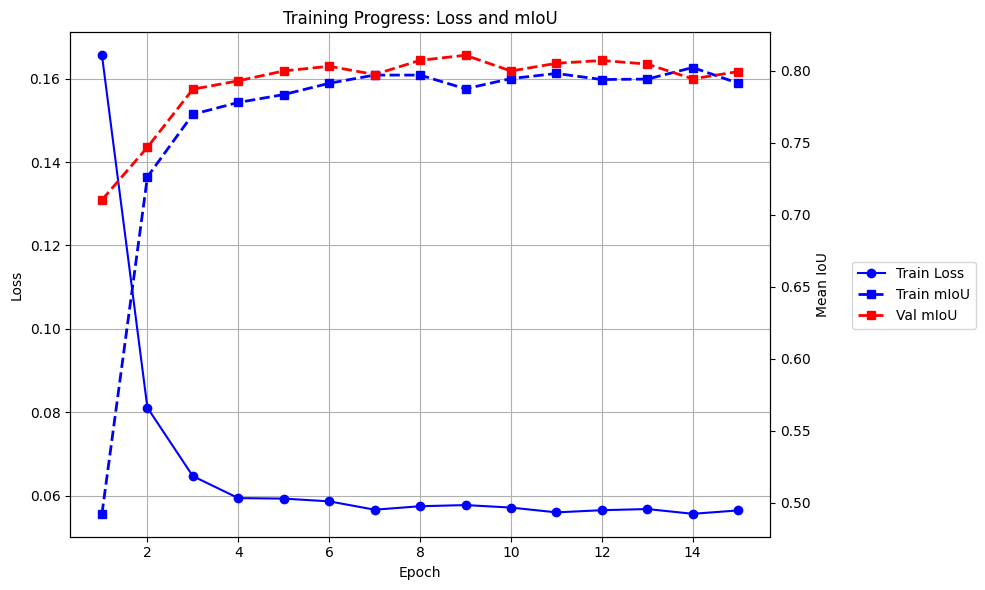

In [25]:
plot_detection_history(history)

In [26]:
# Итоговый результат работы модели
import matplotlib.patches as patches
from torchvision import transforms

def detect_and_visualize(model, image, device, threshold=0.5):
    """
    Detect objects in an image and visualize bounding boxes.

    Args:
        model: Trained Fast R-CNN model.
        image: PIL Image or NumPy array.
        device: torch.device ('cuda' or 'cpu').
        threshold: Score threshold to filter weak detections.

    Returns:
        num_objects: Number of objects detected above the threshold.
    """
    model.eval()

    # Transform the image
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    img_tensor = transform(image).to(device)
    img_tensor = img_tensor.unsqueeze(0)  # add batch dimension

    with torch.no_grad():
        predictions = model(img_tensor)

    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    # Filter boxes by score threshold
    keep = scores >= threshold
    boxes = boxes[keep]
    labels = labels[keep]

    num_objects = len(boxes)

    # Visualize
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box in boxes:
        x1, y1, x2, y2 = box.cpu().numpy()
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

    return num_objects


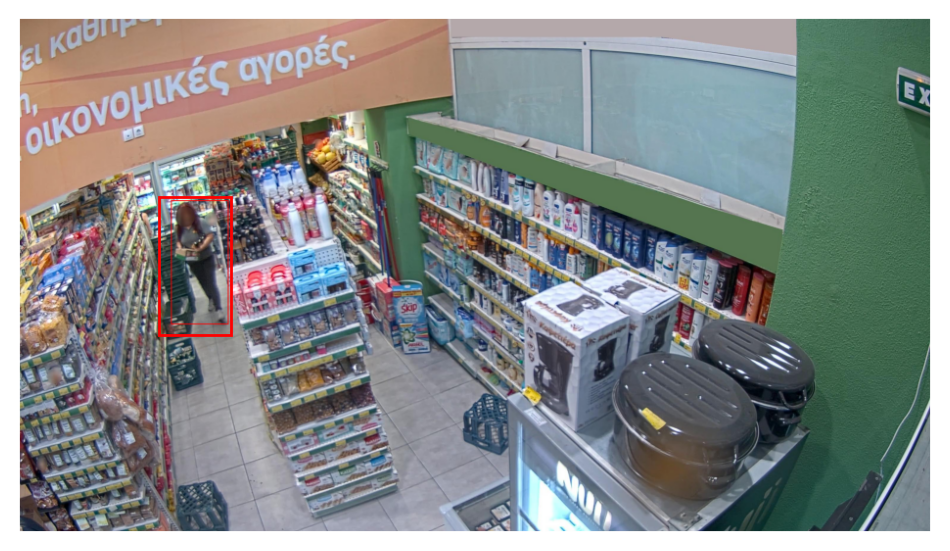

Detected 1 objects


In [27]:
from PIL import Image

image = Image.open("test_image.jpg").convert("RGB")
num_objects = detect_and_visualize(model, image, device)
print(f"Detected {num_objects} objects")

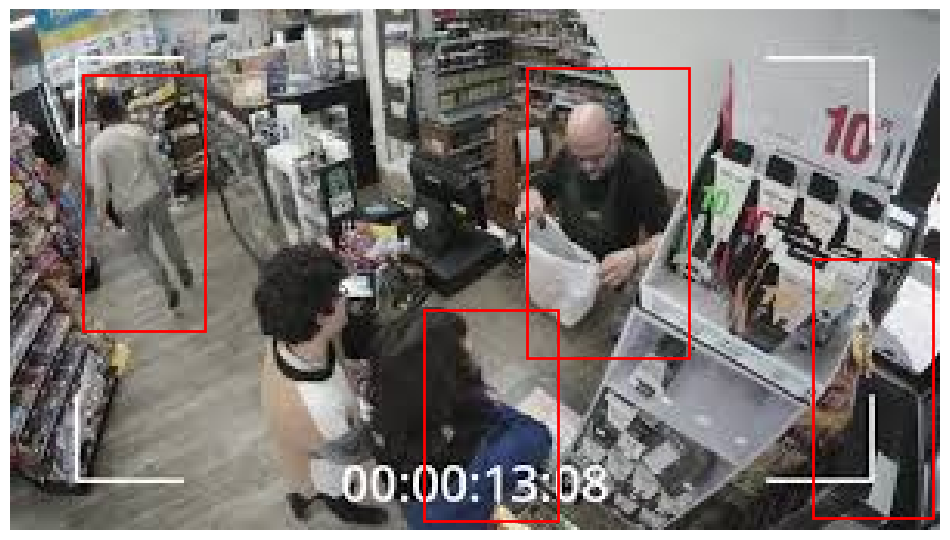

Detected 4 objects


In [35]:
# второй тест
image = Image.open("test_image2.jpg").convert("RGB")
num_objects = detect_and_visualize(model, image, device, threshold = 0.2)
print(f"Detected {num_objects} objects")

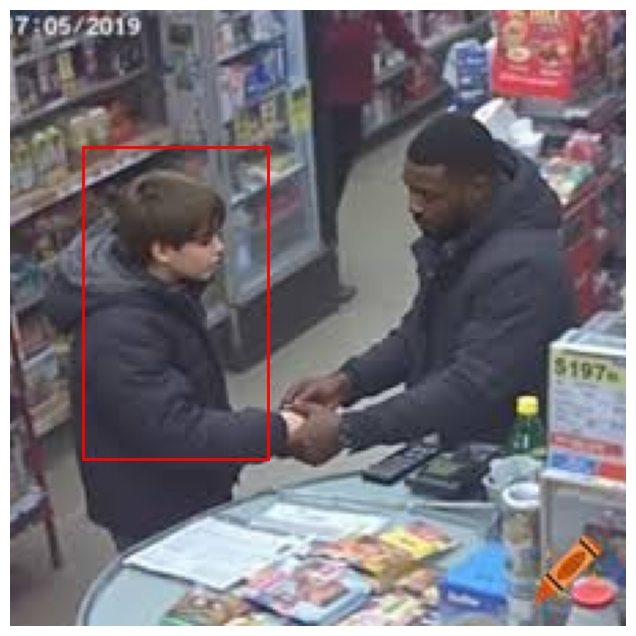

Detected 1 objects


In [36]:
image = Image.open("test_image3.jpg").convert("RGB")
num_objects = detect_and_visualize(model, image, device, threshold = 0.1)
print(f"Detected {num_objects} objects")

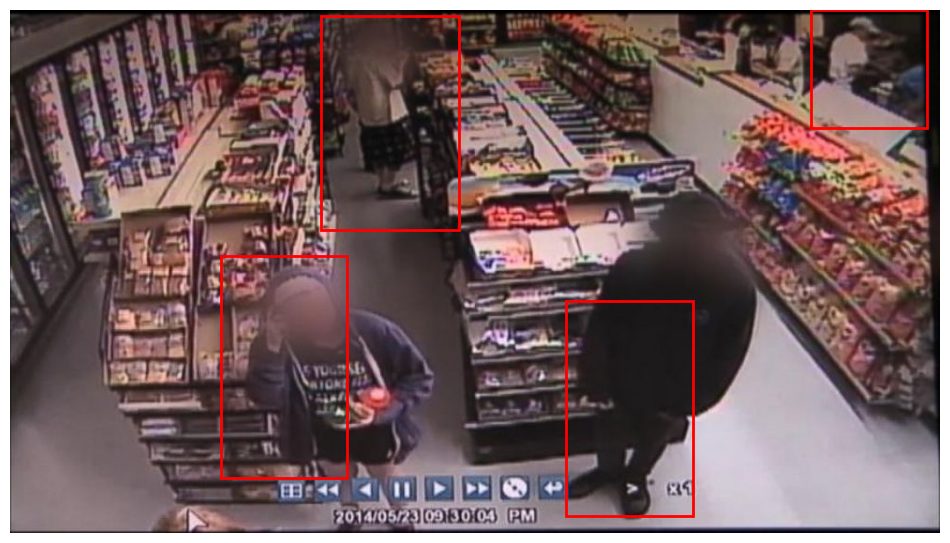

Detected 4 objects


In [37]:
image = Image.open("test_image4.jpg").convert("RGB")
num_objects = detect_and_visualize(model, image, device, threshold = 0.3)
print(f"Detected {num_objects} objects")

In [31]:
# полученные метрики
for k, v in zip(history.keys(), history.values()):
  print(f'{k} : {v[len(v)-1]:.4f}')

train_loss : 0.0564
train_mIoU : 0.7913
val_mIoU : 0.7994
